# Smart Possum

**Deliverable** An application that reduces fatalities and serious injuries from vehicle accidents by raising driver awareness of potential dangers and recommending appropriate responses. Dangers could be predicted by road function (interstate, collector, etc.), area (urban vs. rural), configuration (4-way stop, right hand curve, etc).

**Scope**  United States only. Ignores well known factors, such as driving under the influence, speeding, etc. to focus on environmental and behavioral factors.

**Data** Detailed accident data from the Fatality Analysis Reporting System FARS managed by the U.S. National Highway Traffic Safety Administration NHTSA. Data are available for the years 1975-2014 as dBase and SAS files.

## Setup

### Import

In [2]:
import matplotlib
import pandas as pd

%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

"""
import bokeh
import dbf
import math

import numpy as np
import os

import re
import requests
import sklearn as sk
import scipy.misc
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import xlrd
import zipfile

from ftplib import FTP
from itertools import cycle"""



'\nimport bokeh\nimport dbf\nimport math\n\nimport numpy as np\nimport os\n\nimport re\nimport requests\nimport sklearn as sk\nimport scipy.misc\nimport seaborn as sns\nimport statsmodels.api as sm\nimport statsmodels.formula.api as smf\nimport xlrd\nimport zipfile\n\nfrom ftplib import FTP\nfrom itertools import cycle'

## Classes

### CodeBook
*class* **`CodeBook`**(*dict*)  
*methods*  
**`.add_feature`**(*feature, codes, labels, drop_index=True*)  

In [10]:
"""
        ========================================================================
        class       CodeBook(dict)
        ========================================================================
        
        ========================================================================
        method      add_feature(self, feature, codes, labels, drop_index=False)
        ========================================================================
      
        parameters  feature: string
                      Name of feature
                    codes: tuple, list, pd.Series
                      Codes for each feature value
                    labels: tuple, list, pd.Series
                      Text labels for each feature value
                    drop_index: boolean, default False
                      If True, drops id column when setting index
                      
        returns     None
      
        example     codebook       = CodeBook()
                    codes  = (1, 2, 99)
                    labels = ('rural', 'urban', 'unknown')
                    codebook.add_feature('rur_urb', codes, labels)
                    print codebook['rur_urb']
             
             
                             rur_urb rur_urb_label
                    rur_urb                     
                    1              1         rural
                    2              2         urban
                    99            99       unknown
"""

class CodeBook(dict):
    
    def add_feature(self, feature, codes, labels, drop_index=False):
        feature_label = '{f}_label'.format(f=feature)
        feature_df    = pd.DataFrame({feature:       codes,
                                      feature_label: labels})
        feature_df.set_index(feature, drop=drop_index, inplace=True)
        self[feature] = feature_df

## Functions

### read_worksheet

*function* **`read_worksheet`**(*x, y, z, with_default=True*) 

`|--------||--------||--------||--------80--------||--------||--------||--------|`

In [11]:
"""
    ============================================================================
    function     read_worksheet(excel_file, ids, txts, drop_index=True)
    ============================================================================
    
    parameters   feature: string
                   Name of feature
                 ids: tuple, list, pd.Series
                   Codes for each feature value
                 txts: tuple, list, pd.Series
                   Text descriptions for each feature value
                 drop_index: boolean, default True
                   If True, drops id column when setting index
      
    returns      codebook: pd.DataFrame, columns [*feature*, feature_txt]
                                         rows [id, txt]                                
    
    example      ids = (1, 2, 99)
                 txt = ('rural', 'urban', 'unknown')
                 rural_urban = create_codebook('rur_urb', ids, txts, False)
                 print rural_urban
             
             
                          rur_urb rur_urb_txt
                 rur_urb                     
                 1              1       rural
                 2              2       urban
                 99            99     unknown
                   
"""  


def read_worksheet(excel_file, first_row_value, last_row_value, column_names, track=False):
    if (track==True):
        print 'in read_excel: working with file {ef}'.format(ef=excel_file)
    with pd.ExcelFile(excel_file) as excel:
        try:
            df = excel.parse(str(excel.sheet_names[0]), convert_float=True)
            if (track==True):
                print 'trying sheet {sn}'.format(sn=str(excel.sheet_names[0])) 
            first_row = df.index[df.iloc[:,0].str.contains(first_row_value)==True][0]
            last_row = df.index[df.iloc[:,0].str.contains(last_row_value)==True][0]
        except:
            df = excel.parse(str(excel.sheet_names[1]), convert_float=True)
            first_row = df.index[df.iloc[:,0].str.contains(first_row_value)==True][0]
            last_row = df.index[df.iloc[:,0].str.contains(last_row_value)==True][0]
            if (track==True):
                print 'switched to sheet {sn}'.format(sn=str(excel.sheet_names[1]))
    if (track==True):
        print 'finished parsing'
    table = df.iloc[first_row:last_row+1]
    table.columns = column_names
    return table

### organized_save

*function* **`read_worksheet`**(*x, y, z, with_default=True*) 

In [ ]:
def save_table():

In [11]:
def convert_dbf(dbf_filename):
    d = dbf.Table(dbf_filename, ignore_memos=True)
    d.open()
    c = '%s.csv' % dbf_filename[:-4]
    dbf.export(d, filename=c, format='csv', header=True)
    d.close()

### Parameters

In [12]:
accident_path       =  'ftp.nhtsa.dot.gov'                                      # ftp url of parent directory for FARS & GES data
traffic_path        =  'http://www.fhwa.dot.gov/policyinformation/statistics/'
glc_url             =  'http://www.gsa.gov/portal/getMediaData?mediaId=214171'
glc_file            =  'data/gsa/geographic_location_code.xlsx'
username            =  'anonymous'
password            =  'jonathan.owen@msn.com'
first_state         =  'Alabama'
last_state          =  'Wyoming'

### Lists & Sets

In [13]:
years               =  range(2010, 2016)

In [14]:
accident_tables     = ('accident',
                       'cevent',
                       'person',
                       'vehicle')
traffic_tables      = ('vm2',
                       'mv1',
                       'hm60')

In [6]:
vehicle_types       = ('car',
                       'bus',
                       'truck',
                       'motorcycle',
                       'all motor vehicles')

registration_types = []
for vehicle_type in vehicle_types:
    for ownership in ('private ', 'public ', 'total '):
        registration_types.append(ownership + vehicle_type)

In [7]:
months = ('jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec')
tvt_road_group = ('rural arterial', 'urban arterial', 'all road functions total')
skip_rows = (7, 18, 29, 43, 53)
skip_footers = (53, 42, 28, 18, 3)

## Dictionaries

### codebook

In [15]:
codebook = CodeBook()

In [16]:
func_sys_codes  = (1, 2, 3, 4, 5, 6, 7, 99, 1000)
func_sys_labels = ('interstate',
                   'freeway',
                   'principal arterial',
                   'minor arterial',
                   'major collector',
                   'minor collector',
                   'local',
                   'unknown',
                   'total')
codebook.add_feature('func_sys', func_sys_codes, func_sys_labels, False)

In [17]:
rur_urb_codes  = (1, 2, 99)
rur_urb_labels = ('rural', 'urban', 'unknown')
codebook.add_feature('rur_urb', rur_urb_codes, rur_urb_labels, False)

In [116]:
road_fnc = (1, 2, 3, 4, 5, 6, 9, 11, 12, 13, 14, 15, 16, 19, 99)
road_functions = pd.DataFrame({'road_fnc': road_fnc,
                               'rur_urb' : [1]*7 + [2]*7 + [99],
                               'func_sys': (1, 3, 4, 5, 6, 7, 99, 1, 2, 3, 4, 5, 7, 99, 99)})
road_functions.set_index('road_fnc', drop=False, inplace=True)      

### Dictionaries

In [8]:
traffic_table_format  = {}
traffic_table_default = {}
traffic_table_default['vm2']  = {'excel_extension': '.xls',
                                 'column_names': ['state_name'] +
                                                 road_functions +
                                                 ['all road functions total']}
traffic_table_default['mv1']  = {'excel_extension': '.xlsx',
                                 'column_names': ['state'] +
                                                 registration_types}
traffic_table_default['hm60'] = traffic_table_default['vm2']
                                 
for t in traffic_tables:
    traffic_table_format[t] = {}
    for y in years:
        if (t=='mv1' and y==2010):
            traffic_table_format[t][y] = {'excel_extension': '.xls',
                                          'column_names': ['state'] +
                                                          registration_types[0:6] +
                                                          ['blank'] +
                                                          registration_types[6:9] +
                                                          registration_types[12:15] +
                                                          ['per_capita'] +
                                                          registration_types[9:11]}
        else:
            traffic_table_format[t][y] = traffic_table_default[t]

## Data

## Data: Download
Accident data available from ftp.nhtsa.dot.gov. Zipped DBF files (FoxPro, xBase, *etc*. database format) are in `fars\DBF` folders.

### Accident:  FARS Fatality Analysis Reporting System 

In [11]:
ftp = FTP(accident_path)
ftp.login(username,password)
ftp.cwd('/fars' % y)
for y in years:
    if y < 2012:
        ftp_file = '{y}/DBFFARS{y}.zip'.format(y=y)
    elif y > 2012:
        ftp_file = '{y}/NationalFARS{y}NationalDBF.zip'.format(y=y)
    else:
        ftp.cwd('/fars/' % y)
        ftp_file = '{y}/National/DBFFARS{y}.zip'.format(y=y)
    with open('data/zip/fars/FARS{y}NationalDBF.zip'.format(y=y), 'wb') as local_file:
        ftp.retrbinary('RETR {ftp_file}'.format(ftp_file=ftp_file), local_file.write)
ftp.close()

### Accident: GES General Estimate System

In [7]:
ftp = FTP(accident_path)
ftp.login(username,password)
ftp.cwd('/GES')
for y in years:
    y2 = str(y)[2:4]
    if y < 2014:
        ftp_file = 'GES{y2}/GES{y2}_Flatfile.zip'.format(y2=y2)
    elif y > 2014:
        ftp_file = 'GES{y2}/GES{y}txt.zip'.format(y2=y2, y=y)
    else:
        ftp_file = 'GES{y2}/GES{y}flat.zip'.format(y2=y2, y=y)
    with open('data/zip/ges/GES{y}.zip'.format(y=y), 'wb') as local_file:
        ftp.retrbinary('RETR {ftp_file}'.format(ftp_file=ftp_file), local_file.write)
ftp.close()

##### unzip to data/year directories

In [9]:
for y in years:
    with zipfile.ZipFile('data/zip/fars/FARS_{y}.zip'.format(y=y), 'r') as z:
        z.extractall('data/{y}/fars'.format(y=y))
    with zipfile.ZipFile('data/zip/ges/GES_{y}.zip'.format(y=y), 'r') as z:
        z.extractall('data/{y}/ges'.format(y=y))

###  Traffic: FHWA Vehicle miles, lane miles, & vehicle registration

In [ ]:
for y in years[:-1]:
    for t in traffic_tables:
        excel_extension = traffic_table_format[t][y]['excel_extension']
        traffic_url = '{traffic_path}{y}/xls/{t}{excel_extension}'.format(traffic_path=traffic_path,
                                                                         y=y, t=t, 
                                                                         excel_extension=excel_extension)
        outfile = 'data/{y}/fhwa/{t}{excel_extension}'.format(y=y, t=t, excel_extension=excel_extension)
        url = requests.get(traffic_url)
        with open(outfile, 'wb') as local_file:
            local_file.write(url.content) 

### Traffic: FHWA TVT traffic monitoring

In [17]:
for m in months:
    tvt_month_tables = []
    if m == 'jan':
        y = years[-1] + 1
    else:
        y = years[-1]
    y2 = str(y)[2:4]
    month_url = '{traffic_path}travel_monitoring/{y2}{m}tvt/{y2}{m}tvt.xls'.format(traffic_path=traffic_path[:-11],
                                                                                   y2=y2, m=m)
    tvt_file = 'data/{y}/fhwa/{y2}{m}tvt.xls'.format(y=years[-1], y2=y2, m=m)
    url = requests.get(month_url)
    with open(tvt_file, 'wb') as local_file:
        local_file.write(url.content)

### Location: GLC Geographic Location Codes

In [ ]:
url = requests.get(glc_url)
with open(glc_file, 'wb') as local_file:
    local_file.write(url.content) 

### Data: Load

### Accident: FARS & GES

##### convert DBF to CSV files

In [ ]:
for t in accident_tables:
    for y in years:
        dbf_file = 'data/{y}/fars/{t}.dbf'.format(y=y, t=t)
        convert_dbf(dbf_file)

##### read accident data from CSV and TXT files

In [12]:
fars, ges = {},{}
for t in accident_tables:
    fars_tables, ges_tables = [],[]
    for y in years:
        with open('data/{y}/fars/{t}.csv'\
                  .format(y=y, t=t),'r') as local_file:
            df = pd.read_csv(local_file)
            if t != 'accident':
                df['year'] = y
            fars_tables.append(df)
        if y == 2010:
            txt ='TXT/{t}'.format(t=t.upper())
        else:
            txt = t.upper()
        with open('data/{y}/ges/{txt}.txt'.format(y=y, txt=txt), 'r') as local_file:
            ges_tables.append(pd.read_table(local_file))
    fars_table = pd.concat(fars_tables, ignore_index=True)
    ges_table = pd.concat(ges_tables, ignore_index=True)
    fars[t], ges[t] = fars_table, ges_table
for t in accident_tables:
    fars[t].set_index(['year', 'st_case'] , drop=False, inplace=True)

E:\Users\jonat_000\Anaconda3\envs\Python 2.7\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (49,50) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
E:\Users\jonat_000\Anaconda3\envs\Python 2.7\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (60,61) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
E:\Users\jonat_000\Anaconda3\envs\Python 2.7\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
E:\Users\jonat_000\Anaconda3\envs\Python 2.7\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (36,37) have mixed types. Specify dtype option on import or set

### Traffic: FHWA

##### read FHWA traffic data from XLS and XLSX files

In [13]:
fhwa = {}
for t in traffic_tables:
    fhwa_tables = []
    for y in years[:-1]:
        excel_extension = traffic_table_format[t][y]['excel_extension']
        fhwa_excel = 'data/{y}/fhwa/{t}{excel_extension}'.format(y=y, t=t, excel_extension=excel_extension)
        fhwa_table = read_excel(fhwa_excel, first_state, last_state, traffic_table_format[t][y]['column_names'])
        fhwa_table['year'] = y
        fhwa_tables.append(fhwa_table)
    fhwa[t]= pd.concat(fhwa_tables, ignore_index=True)

### Location: GLC

##### read GLC data from XLSX file

In [14]:
with pd.ExcelFile(glc_file) as excel:
    glc = excel.parse('Sheet 1', skiprows=1, skip_footer=2, convert_float=True)

### Data: Clean

#### Standardize state names

In [15]:
glc['State Name'] = glc['State Name'].str.title()

In [16]:
state_names = glc['State Name'].unique()

In [17]:
state_sequence = cycle(state_names)
for t in traffic_tables:
    fhwa[t]['state'] = [next(state_sequence) for count in range(fhwa[t].shape[0])]

### Traffic: Impute FHWA `vm2` vehicle miles for 2015

In [18]:
tvt_month_tables = []
for m in months:
    if m == 'jan':
        y = years[-1] + 1
    else:
        y = years[-1]
    y2 = str(y)[2:4]
    tvt_file = 'data/{yr}/fhwa/{y2}{m}tvt.xls'.format(yr=years[-1], y2=y2, m=m)
    tvt_road_tables = []
    for i in range(3):
        if i==2:
            extra_footer_rows = 3
        else:
            extra_footer_rows = 0
        with pd.ExcelFile(tvt_file) as excel:
            tvt_region_tables = []
            for j in range(5):
                tvt_region_table = excel.parse('Page {page_number}'.format(page_number = i + 4),
                                               skiprows=skip_rows[j],
                                               skip_footer=skip_footers[j] + extra_footer_rows,
                                               parse_cols=[0,8])
                tvt_region_table.columns = ['state'] + [tvt_road_group[i]]
                tvt_region_tables.append(tvt_region_table)
            tvt_road_table = pd.concat(tvt_region_tables, ignore_index=True)
        tvt_road_tables.append(tvt_road_table)
    tvt_month_table = pd.concat(tvt_road_tables, axis=1)
    tvt_month_tables.append(tvt_month_table)
tvt = pd.concat(tvt_month_tables, ignore_index=True)    

In [19]:
tvt.columns = ['state', 'rural arterial', 'state_1', 'urban arterial', 'state_2', 'all road functions total']
tvt.drop(['state_1', 'state_2'], axis=1, inplace=True)
tvt['state'] = tvt['state'].str.title()

In [20]:
tvt_2015 = tvt.groupby(['state'], as_index=False)[tvt_road_group].sum()

In [21]:
tvt_2015['non arterial'] = tvt_2015['all road functions total'] -  tvt_2015['urban arterial'] -  tvt_2015['rural arterial']

In [22]:
vm2 = fhwa['vm2']
vm2['rural arterial'] = vm2['rural interstate'] + vm2['rural freeway'] + vm2['rural principal arterial'] + vm2['rural minor arterial']
vm2['urban arterial'] = vm2['urban interstate'] + vm2['urban freeway'] + vm2['urban principal arterial'] + vm2['urban minor arterial']
vm2['non arterial'] = vm2['all road functions total'] - vm2['urban arterial'] -  vm2['rural arterial']

In [23]:
vm2['rural interstate fraction'] = vm2['rural interstate']/(vm2['rural arterial']+(vm2['rural arterial']==0))
vm2['rural freeway fraction'] = vm2['rural freeway']/(vm2['rural arterial']+(vm2['rural arterial']==0))
vm2['rural principal arterial fraction'] = vm2['rural principal arterial']/(vm2['rural arterial']+(vm2['rural arterial']==0))
vm2['rural minor arterial fraction'] = vm2['rural minor arterial']/(vm2['rural arterial']+(vm2['rural arterial']==0))

In [24]:
vm2['urban interstate fraction'] = vm2['urban interstate']/(vm2['urban arterial']+(vm2['urban arterial']==0))
vm2['urban freeway fraction'] = vm2['urban freeway']/(vm2['urban arterial']+(vm2['urban arterial']==0))
vm2['urban principal arterial fraction'] = vm2['urban principal arterial']/(vm2['urban arterial']+(vm2['urban arterial']==0))
vm2['urban minor arterial fraction'] = vm2['urban minor arterial']/(vm2['urban arterial']+(vm2['urban arterial']==0))

In [25]:
vm2['rural major collector fraction'] = vm2['rural major collector']/(vm2['non arterial']+(vm2['non arterial']==0))
vm2['rural minor collector fraction'] = vm2['rural minor collector']/(vm2['non arterial']+(vm2['non arterial']==0))
vm2['rural local fraction'] = vm2['rural local']/(vm2['non arterial']+(vm2['non arterial']==0))
vm2['urban major collector fraction'] = vm2['urban major collector']/(vm2['non arterial']+(vm2['non arterial']==0))
vm2['urban minor collector fraction'] = vm2['urban minor collector']/(vm2['non arterial']+(vm2['non arterial']==0))
vm2['urban local fraction'] = vm2['urban local']/(vm2['non arterial']+(vm2['non arterial']==0))

In [26]:
vm2_2015 = pd.merge(tvt_2015, vm2[vm2.year==2014], on='state')

In [27]:
vm2_2015['rural interstate'] = vm2_2015['rural interstate fraction'] * vm2_2015['rural arterial_x']
vm2_2015['rural freeway'] = vm2_2015['rural freeway fraction'] * vm2_2015['rural arterial_x']
vm2_2015['rural principal arterial'] = vm2_2015['rural principal arterial fraction'] * vm2_2015['rural arterial_x']
vm2_2015['rural minor arterial'] = vm2_2015['rural minor arterial fraction'] * vm2_2015['rural arterial_x']

In [28]:
vm2_2015['urban interstate'] = vm2_2015['urban interstate fraction'] * vm2_2015['urban arterial_x']
vm2_2015['urban freeway'] = vm2_2015['urban freeway fraction'] * vm2_2015['urban arterial_x']
vm2_2015['urban principal arterial'] = vm2_2015['urban principal arterial fraction'] * vm2_2015['urban arterial_x']
vm2_2015['urban minor arterial'] = vm2_2015['urban minor arterial fraction'] * vm2_2015['urban arterial_x']

In [29]:
vm2_2015['rural major collector'] = vm2_2015['rural major collector fraction'] * vm2_2015['non arterial_x']
vm2_2015['rural minor collector'] = vm2_2015['rural minor collector fraction'] * vm2_2015['non arterial_x']
vm2_2015['rural local'] = vm2_2015['rural local fraction'] * vm2_2015['non arterial_x']
vm2_2015['urban major collector'] = vm2_2015['urban major collector fraction'] * vm2_2015['non arterial_x']
vm2_2015['urban minor collector'] = vm2_2015['urban minor collector fraction'] * vm2_2015['non arterial_x']
vm2_2015['urban local'] = vm2_2015['urban local fraction'] * vm2_2015['non arterial_x']

In [30]:
vm2_2015.drop(['rural arterial_y', 'urban arterial_y', 'non arterial_y', 'all road functions total_y'], axis=1, inplace=True)

In [31]:
vm2_2015.columns = ['state',
                    'rural arterial',
                    'urban arterial',
                    'all road functions total',
                    'non arterial', 
                    'rural interstate',
                    'rural freeway',
                    'rural principal arterial',
                    'rural minor arterial',
                    'rural major collector',
                    'rural minor collector',
                    'rural local',
                    'rural total',
                    'urban interstate',
                    'urban freeway',
                    'urban principal arterial',
                    'urban minor arterial',
                    'urban major collector',
                    'urban minor collector',
                    'urban local',
                    'urban total',
                    'year',
                    'rural interstate fraction',
                    'rural freeway fraction',
                    'rural principal arterial fraction',
                    'rural minor arterial fraction', 
                    'urban interstate fraction',
                    'urban freeway fraction',
                    'urban principal arterial fraction',
                    'urban minor arterial fraction',
                    'rural major collector fraction',
                    'rural minor collector fraction',
                    'rural local fraction',
                    'urban major collector fraction',
                    'urban minor collector fraction',
                    'urban local fraction']

In [32]:
vm2_2015['year'] = 2015

In [33]:
fhwa['vm2'] = pd.concat([vm2, vm2_2015], ignore_index=True)

In [34]:
fhwa['vm2'].to_csv('data/save/vm2.csv')

### Accident: Map FARS `road_fnc` road function to `rur_urb` land use and `func_sys` functional system 

In [35]:
fars_before_2015 = fars['accident'].loc[fars['accident'].year!=2015,]
temp_map = fars_before_2015.road_fnc.map(road_function_map.func_sys)
fars['accident'].loc[fars['accident'].year!=2015,'func_sys'] = temp_map
fars['accident'].func_sys = fars['accident'].func_sys.astype(int)
temp_map = fars_before_2015.road_fnc.map(road_function_map.rur_urb)
fars['accident'].loc[fars['accident'].year!=2015,'rur_urb'] = temp_map
fars['accident'].rur_urb = fars['accident'].rur_urb.astype(int)

### Traffic: Melt FHWA `vm2` vehicle miles

In [82]:
vm2_temp = fhwa['vm2'][['state']+['year']+road_functions]
vm2_temp.drop(['rural total', 'urban total'], axis=1, inplace=True)

E:\Users\jonat_000\Anaconda3\envs\Python 2.7\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [83]:
vm2_temp.set_index(['state', 'year'], inplace=True)

In [84]:
vm2_stack = vm2_temp.stack()

In [85]:
vm2_stack = vm2_stack.to_frame()
vm2_stack.columns = ['vehicle miles']

In [86]:
rur, urb = [1]*7, [2]*7
rur_urb = rur+urb
rur_urb_sequence = cycle(rur_urb)
func_sys_sequence = cycle(range(1,8))
vm2_stack['rur_urb'] = [next(rur_urb_sequence) for count in range(vm2_stack.shape[0])]
vm2_stack['func_sys'] = [next(func_sys_sequence) for count in range(vm2_stack.shape[0])]

In [87]:
vm2_stack['state'] = vm2_stack.index.get_level_values(0)
vm2_stack['year'] = vm2_stack.index.get_level_values(1)
vm2_stack['road function'] = vm2_stack.index.get_level_values(2)

In [88]:
vm2_stack.set_index(['state', 'year', 'rur_urb', 'func_sys'], drop=False, inplace=True)

In [89]:
vm2_stack

vehicle miles  rur_urb  func_sys  \
state         year rur_urb func_sys                                    
Alabama       2010 1       1              5744.61        1         1   
                           2                    0        1         2   
                           3              6503.18        1         3   
                           4              4800.23        1         4   
                           5              4983.95        1         5   
                           6              1685.57        1         6   
                           7              6851.41        1         7   
                   2       1              7552.17        2         1   
                           2              591.211        2         2   
                           3              7460.65        2         3   
                           4              6192.35        2         4   
                           5              3273.78        2         5   
                           6                    0        2         6   
                           7              8526.03        2         7   
Alaska        2010 1       1              858.996        1         1   
                           2                    0        1         2   
                           3              310.174        1         3   
                           4               114.34        1         4   
                           5              352.007        1         5   
                           6              150.015        1         6   
                           7               419.02        1         7   
                   2       1              663.146        2         1   
                           2                    0        2         2   
                           3              491.211        2         3   
                           4               798.27        2         4   
                           5                    0        2         5   
                           6              349.813        2         6   
                           7               291.27        2         7   
Arizona       2010 1       1              7132.91        1         1   
                           2                    0        1         2   
...                                           ...      ...       ...   
West Virginia 2015 2       6                    0        2         6   
                           7              266.279        2         7   
Wisconsin     2015 1       1              5164.95        1         1   
                           2              1559.07        1         2   
                           3              7045.88        1         3   
                           4               5256.1        1         4   
                           5              7415.53        1         5   
                           6              1930.87        1         6   
                           7              3656.89        1         7   
                   2       1              5753.54        2         1   
                           2               5208.3        2         2   
                           3              8996.14        2         3   
                           4              5428.02        2         4   
                           5               2509.6        2         5   
                           6                    0        2         6   
                           7              2378.12        2         7   
Wyoming       2015 1       1              2560.66        1         1   
                           2                    0        1         2   
                           3              1642.97        1         3   
                           4              551.362        1         4   
                           5              608.056        1         5   
                           6              747.679        1         6   
                           7              639.162        1         7   
    

### Accident: Sum fatalities

In [73]:
state_series = pd.Series(glc['State Name'].unique(), index = glc['State Code'].unique())

In [76]:
fars['accident']['state_name'] = fars['accident']['state'].map(state_series)

In [78]:
fatality_sums = fars['accident'].groupby(['state_name', 'year', 'rur_urb', 'func_sys'], as_index=False)['fatals'].sum()

In [79]:
fatality_sums

,state_name,year,rur_urb,func_sys,fatals
0,Alabama,2010,1,1,50
1,Alabama,2010,1,3,119
2,Alabama,2010,1,4,74
3,Alabama,2010,1,5,78
4,Alabama,2010,1,6,35
5,Alabama,2010,1,7,169
6,Alabama,2010,1,99,2
7,Alabama,2010,2,1,43
8,Alabama,2010,2,2,71
9,Alabama,2010,2,3,13


In [90]:
fatality_sums.shape

(3750, 5)

In [99]:
fatality_merged = fatality_sums.merge(vm2_stack, 
                                      left_on = ['state_name', 'year', 'rur_urb', 'func_sys'],
                                      right_on = ['state', 'year', 'rur_urb', 'func_sys'])
fatality_merged.drop('state', axis=1, inplace=True)

In [100]:
fatality_merged

,state_name,year,rur_urb,func_sys,fatals,vehicle miles,road function
0,Alabama,2010,1,1,50,5744.61,rural interstate
1,Alabama,2010,1,3,119,6503.18,rural principal arterial
2,Alabama,2010,1,4,74,4800.23,rural minor arterial
3,Alabama,2010,1,5,78,4983.95,rural major collector
4,Alabama,2010,1,6,35,1685.57,rural minor collector
5,Alabama,2010,1,7,169,6851.41,rural local
6,Alabama,2010,2,1,43,7552.17,urban interstate
7,Alabama,2010,2,2,71,591.211,urban freeway
8,Alabama,2010,2,3,13,7460.65,urban principal arterial
9,Alabama,2010,2,4,76,6192.35,urban minor arterial


In [19]:
vm2_full = excel_dict['vm2']
road_function_upper = ['INTERSTATE', 'FREEWAY OR EXPRESSWAY',
                      'OTHER PRINCIPAL ARTERIAL', 'MINOR ARTERIAL',
                      'MAJOR COLLECTOR', 'MINOR COLLECTOR', 'LOCAL']
road_function_only = []
for rf in road_function_upper:   
    rf = rf.lower()
    rf = re.sub(' ', '_', rf)
    road_function_only.append(rf)
for i in range(1, 8):
    df_rural = vm2_full.loc[:,['FILE_YEAR', 'Unnamed: 0', 'Unnamed: {n}'.format(n=i)]]
    df_rural.columns = ['year', 'state', 'vehicle_miles']
    df_rural['road_area'] = 'rural'
    df_rural['road_function_only'] = road_function_only[i-1]
    df_urban = vm2_full.loc[:,['FILE_YEAR', 'Unnamed: 0', 'Unnamed: {n}'.format(n=i+8)]]
    df_urban.columns = ['year', 'state', 'vehicle_miles']
    df_urban['road_area'] = 'urban'
    df_urban['road_function_only'] = road_function_only[i-1]
    
    if i == 1:
        vm2_melt = pd.concat([df_rural, df_urban], ignore_index=True, axis=0)
    else:
        vm2_melt = pd.concat([vm2_melt, df_rural, df_urban], ignore_index=True, axis=0)
vm2_melt['year'] = pd.to_numeric(vm2_melt['year'])
vm2_melt['state'] = clean_unicode(vm2_melt['state'])
vm2_melt['road_area'] = clean_unicode(vm2_melt['road_area'])
vm2_melt['road_function_only'] = clean_unicode(vm2_melt['road_function_only'])
road_function_xref = vm2_melt.road_function_only.copy()
vm2_melt['road_function_xref'] = road_function_xref
vm2_melt.loc[((vm2_melt['road_function_xref'] == 'minor_collector')|(vm2_melt['road_function_xref'] == 'major_collector'))&
         (vm2_melt['road_area'] == 'urban'),'road_function_xref'] = 'collector'
vm2 =vm2_melt.groupby(['state', 'year', 'road_area','road_function_xref'],as_index=False)['vehicle_miles'].sum()

#### Read road function code table

In [24]:
with open('data/Road_Function_Codes.txt', 'r') as road_file:
    roads = pd.read_table(road_file, header=None, names=['road_fnc', 'road_function_full'])
roads['road_function_full'] = clean_unicode(roads['road_function_full'])
roads['road_area'] = roads.road_function_full.str.split('-',1).str[0]
roads['road_function_only'] = roads.road_function_full.str.split('-',1).str[1]
roads['road_area'] = roads['road_area'].str.lower()
roads['road_function_only'] = roads['road_function_only'].str.lower()
roads['road_function_only'] =  roads['road_function_only'].str.replace('-| ', '_')
roads['road_function_only'] =  roads['road_function_only'].str.replace('local(_\w+)*', 'local')
roads['road_function_only'] =  roads['road_function_only'].str.replace('unknown(_\w+)*', 'unknown')
roads['road_function_only'] =  roads['road_function_only'].str.replace('(\w+_)*interstate', 'interstate')
roads['road_function_only'] =  roads['road_function_only'].str.replace('(\w+_)*freeways_or_expressways', 'freeway_or_expressway')
roads['road_function_only'] =  roads['road_function_only'].str.replace('(\w+_)*interstate', 'interstate')
roads['road_function_only'] =  roads['road_function_only'].str.replace('(\w+_)?principal_arterial(_\w+)?', 
                                                                       'other_principal_arterial')
roads.loc[roads['road_function_only'].isnull(),'road_function_only'] = 'unknown'

#### Join accident table with vehicle miles

In [25]:
accidents = pd.concat(fars['accident'])

In [26]:
new_index=range(accidents.shape[0])
accidents['new_index']=new_index
accidents.set_index('new_index', drop=True, append=False, inplace=True)

In [27]:
"""
        Clean up accidents reports for STATE, ROAD_FNC. YEAR combinations with 
        zero vehicle miles in vm2 table.
        Original ROAD_FNC code replaced by another with same road_area and 
        road_function value when accidents and vm2 tables are merged.
        
        example: ROAD_FNC code 5 (Rural-Minor Collector)
                 replaced by
                 ROAD_FNC code 4 (Rural-Major Collector)
"""

for i in range(accidents.shape[0]-1):
    if accidents.ix[i,'STATE'] in [16, 35, 2, 19, 38] and accidents.ix[i,'ROAD_FNC']==12:
            accidents.ix[i, 'ROAD_FNC'] = 13  
    if accidents.ix[i,'STATE']==38 and accidents.ix[i,'ROAD_FNC']==5:
            accidents.ix[i, 'ROAD_FNC'] = 4
    if accidents.ix[i,'STATE']==15 and accidents.ix[i,'ROAD_FNC']==1:
            accidents.ix[i, 'ROAD_FNC'] = 2 

In [28]:
accidents_roads = pd.merge(accidents, roads,
                           how='left',
                           left_on='ROAD_FNC',
                           right_on='road_fnc')
accidents_roads_glc = pd.merge(accidents_roads, glc, 
                               how='left',
                               left_on=('STATE',
                                        'CITY',
                                        'COUNTY'), 
                               right_on=('State Code',
                                         'City Code',
                                         'County Code'))
accidents_roads_glc['State Name'] = accidents_roads_glc['State Name'].str.title()
accidents_roads_glc['road_area'] = accidents_roads_glc['road_area'].str.lower()
accidents_roads_glc['road_function_only'] = accidents_roads_glc['road_function_only'].str.lower()
accidents_vm2 = pd.merge(accidents_roads_glc, vm2_melt,
                         how='left',
                        left_on=('State Name',
                                 'YEAR',
                                 'road_area',
                                 'road_function_only'),
                        right_on=('state',
                                  'year', 
                                  'road_area',
                                  'road_function_xref'))

In [29]:
accidents_select = ['ARR_HOUR', 'ARR_MIN', 'CF1', 'CF2', 'CF3', 
                    'DAY', 'DAY_WEEK', 'DRUNK_DR', 'FATALS', 'HARM_EV', 
                   'HOSP_HR', 'HOSP_MN', 'HOUR', 'LATITUDE', 'LGT_COND', 
                   'LONGITUD', 'MAN_COLL', 'MILEPT', 'MINUTE', 'MONTH', 
                   'NHS', 'NOT_HOUR', 'NOT_MIN', 'PEDS', 'PERMVIT', 
                   'PERNOTMVIT', 'PERSONS', 'PVH_INVL', 'RAIL', 'RELJCT1', 
                   'RELJCT2', 'REL_ROAD', 'ROUTE', 'SCH_BUS','SP_JUR',
                   'TWAY_ID', 'TWAY_ID2', 'TYP_INT', 'VE_FORMS', 'VE_TOTAL', 
                   'WEATHER', 'WEATHER1', 'WEATHER2', 'WRK_ZONE', 'YEAR', 
                   'STATE', 'ST_CASE','State Abbreviation', 'state', 'CITY', 
                    'COUNTY', 'City Name/County Name', 'ROAD_FNC', 'road_area', 
                   'road_function_xref', 'vehicle_miles']

In [30]:
accidents_rough = accidents_vm2[accidents_select]

In [31]:
accidents_by_vm = accidents_rough.groupby(['YEAR', 
                                           'state', 
                                           'road_area', 
                                           'road_function_xref'] 
                                           , as_index=False).agg(
                                          {'vehicle_miles': lambda x: sum(x)/sum(x>0),
                                           'FATALS': sum})

In [32]:
"""
        Multiply fatalities total FATALS by 0.5 when road_area=urban and 
        road_function_xref=collector because each report is counted twice.
        
"""

accidents_by_vm.loc[(accidents_by_vm['road_area']=='urban') & 
                    (accidents_by_vm['road_function_xref']=='collector'),
                    'FATALS'] = accidents_by_vm['FATALS']*50/100

In [33]:
accidents_by_vm['rate'] = accidents_by_vm['FATALS']/(accidents_by_vm['vehicle_miles']+(accidents_by_vm['vehicle_miles']==0))

In [34]:
road_function_set = set(accidents_by_vm.road_function_xref)
road_function_groups = pd.DataFrame({'road_function_xref':list(road_function_set),
                                     'road_function': ['collector',
                                                       'arterial',
                                                       'arterial', 
                                                       'collector',
                                                       'collector',
                                                       'arterial',
                                                       'local',
                                                       'arterial']})

In [35]:
accidents_by_vm = pd.merge(accidents_by_vm, road_function_groups,
                        left_on=('road_function_xref'),
                        right_on=('road_function_xref'))

In [36]:
"""
        Artificial record added for kde plot aesthetics.
"""

accidents_by_vm.loc[accidents_by_vm.shape[0]] = [2015, 
                                                 'Puerto Rico', 
                                                 'rural',
                                                 'local', 
                                                 20001, 
                                                 0,
                                                 0, 
                                                 'local']

In [37]:
"""
        Check accidents reported against zero vehicle miles.
        There should be none after clean up by reassigning ROAD_FNC.
"""

accidents_by_vm.loc[accidents_by_vm['vehicle_miles']==0,]

,YEAR,state,road_area,road_function_xref,vehicle_miles,FATALS,rate,road_function


In [38]:
accidents_by_vm.rate.max()

0.20942890145481521

In [39]:
accidents_by_vm['log_vehicle_miles']=np.log(accidents_by_vm['vehicle_miles'])
accidents_by_vm['log_fatalities']=np.log(accidents_by_vm['FATALS'])

#### save accidents_by_vm

In [41]:
with open('save/accidents_by_vm.csv', 'w') as avm:
    accidents_by_vm.to_csv(avm)

#### Unzip and read GES tables

In [42]:
"""for y in yrs:
    frames = []
    try:
        with zipfile.ZipFile('data/{yd}/GES{y2}_Flatfile.zip'.format(yd=str(y), y2=str(y)[2:4]), 'r') as z:
            frames.append(pd.read_table(z.open()))
            vehicles = pd.concat(frames)
    except:
        with zipfile.ZipFile('data/{yd}/GES{y4}flat.zip'.format(yd=str(y), y4=str(y), 'r') as z:"""

"for y in yrs:\n    frames = []\n    try:\n        with zipfile.ZipFile('data/{yd}/GES{y2}_Flatfile.zip'.format(yd=str(y), y2=str(y)[2:4]), 'r') as z:\n            frames.append(pd.read_table(z.open()))\n            vehicles = pd.concat(frames)\n    except:\n        with zipfile.ZipFile('data/{yd}/GES{y4}flat.zip'.format(yd=str(y), y4=str(y), 'r') as z:"

## Graphs

### Fatalities vs Vehicle Miles

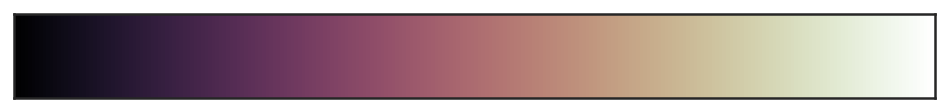

In [43]:
kde_cmap = sns.choose_cubehelix_palette(as_cmap=True)

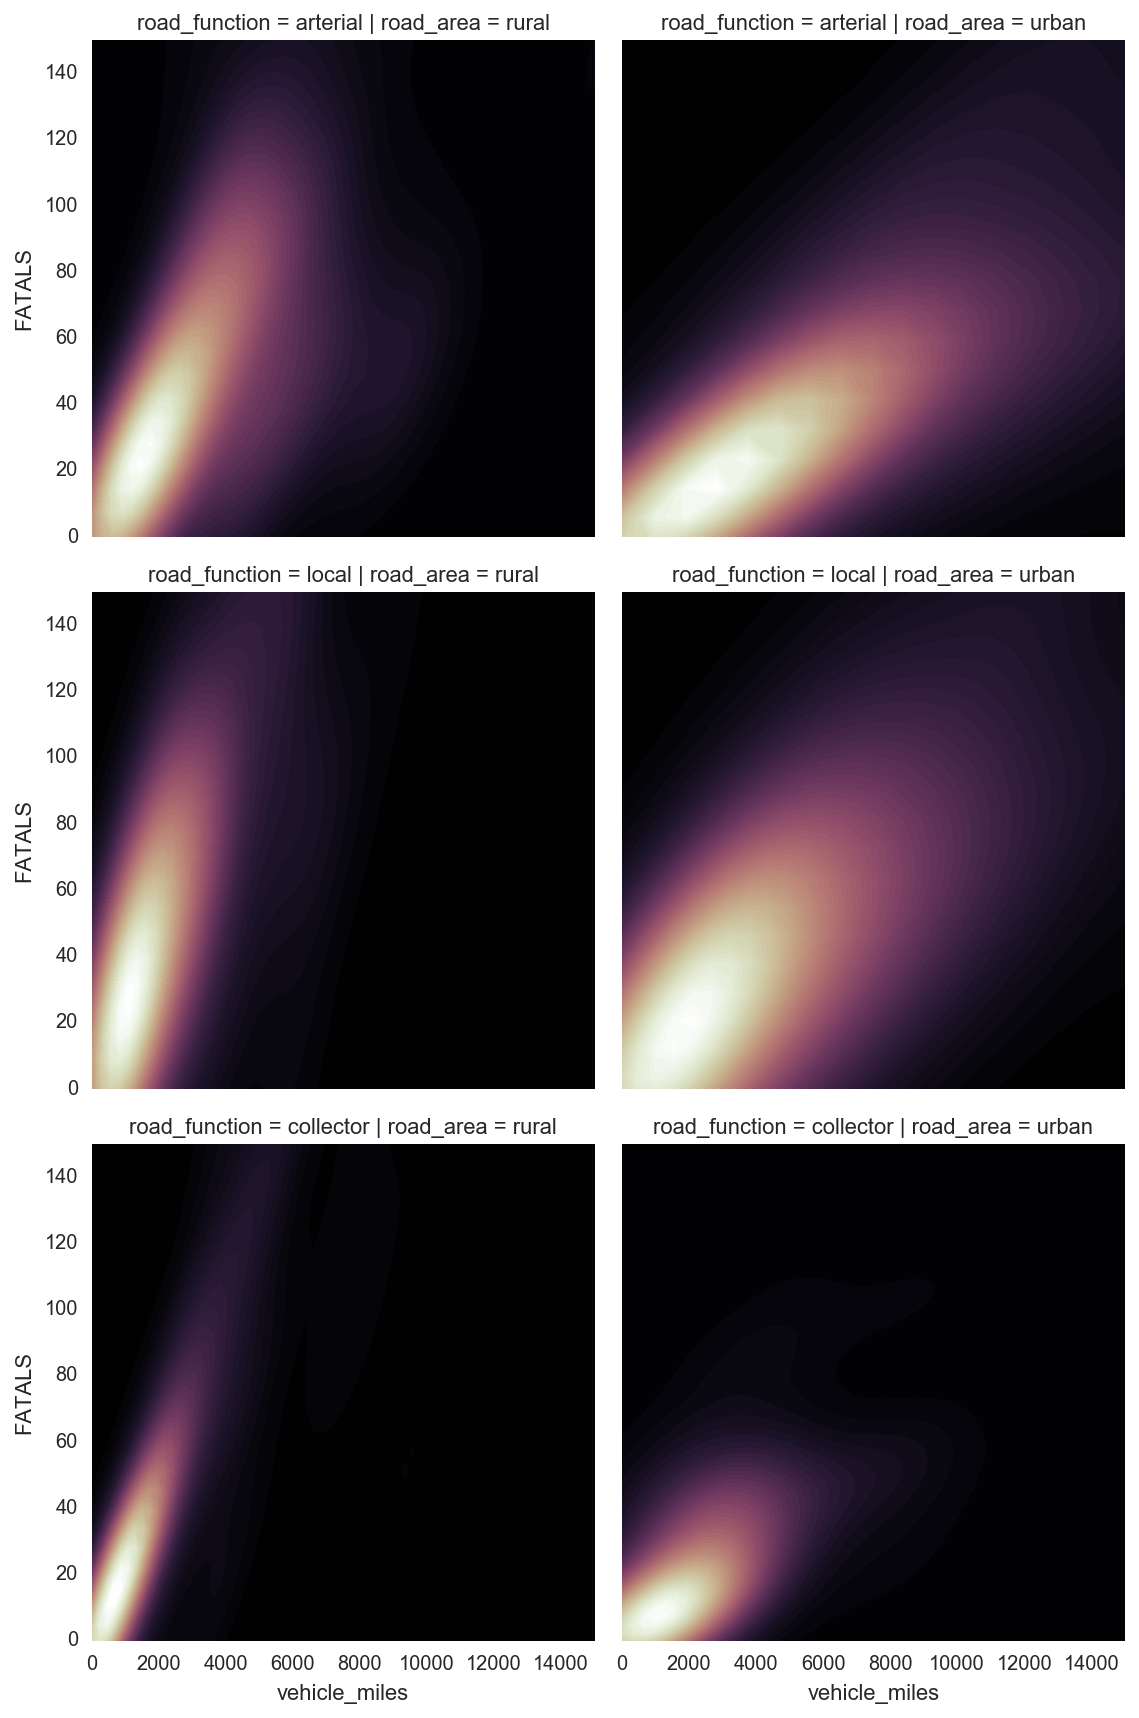

In [44]:
with sns.axes_style("dark"):
    g = sns.FacetGrid(data=accidents_by_vm,
                      row='road_function',
                      col='road_area',
                      size=4)
g.set(xlim=(0,15000), ylim=(0,150))
g.map(sns.kdeplot, 
      "vehicle_miles", 
      "FATALS",
      cmap=kde_cmap,
      n_levels=75,
      shade=True)

In [105]:
"""     
        Older, unused function.
        Intended for removing unicode escape characters from dataframe columns.
"""
"""
def clean_unicode(df_column):
    df_column = df_column.apply(lambda x: x.decode('unicode_escape').encode('ascii', 'ignore').strip())
    return df_column
"""

"\ndef clean_unicode(df_column):\n    df_column = df_column.apply(lambda x: x.decode('unicode_escape').encode('ascii', 'ignore').strip())\n    return df_column\n"

In [106]:
with sns.axes_style("dark"):
    g = sns.FacetGrid(data=accidents_by_vm,
                      row='road_function',
                      col='road_area',
                      hue='road_function_xref',
                      palette="Blues_d",
                      size=4)
#g.set(xlim=(0,15000), ylim=(0,7))
g.map(sns.regplot, 
      'log_vehicle_miles', 
      'log_fatalities',
     robust=True)

NameError: name 'accidents_by_vm' is not defined

## Prediction

### Classes

In [107]:
"""class CreateDicts(sk.base.BaseEstimator, sk.base.TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        self.dict_list = []
        for x_item in X:
            item_dict = {}
            if isinstance(x_item, basestring):
                item_dict[x_item] = 1
            else:
                for item_list in x_item:
                    item_dict[item_list] = 1
            self.dict_list.append(item_dict)
        return self.dict_list """

'class CreateDicts(sk.base.BaseEstimator, sk.base.TransformerMixin):\n    def fit(self, X, y=None):\n        return self\n    \n    def transform(self, X):\n        self.dict_list = []\n        for x_item in X:\n            item_dict = {}\n            if isinstance(x_item, basestring):\n                item_dict[x_item] = 1\n            else:\n                for item_list in x_item:\n                    item_dict[item_list] = 1\n            self.dict_list.append(item_dict)\n        return self.dict_list '

#### `ModelTransformer`()

In [108]:
class ModelTransformer(sk.base.BaseEstimator, sk.base.TransformerMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, *args, **kwargs):
        self.model.fit(*args, **kwargs)
        return self

    def transform(self, X, **transform_params):
        return pd.DataFrame(self.model.predict(X))

### Poisson regression of `FATALS` on `vehicle_miles`

In [109]:
endog = accidents_by_vm['FATALS']
exog = sm.add_constant(accidents_by_vm['vehicle_miles'], prepend=False)

NameError: name 'accidents_by_vm' is not defined

In [110]:
glm_poisson = sm.GLM(endog, exog, family=sm.families.Poisson())
poisson = glm_poisson.fit()

NameError: name 'endog' is not defined

In [111]:
print poisson.summary()

NameError: name 'poisson' is not defined

#### Simulated data from Poisson regression model

In [112]:
rate_coef = poisson.params[0]
const = poisson.params[1]
print rate_coef, const

NameError: name 'poisson' is not defined

In [113]:
models_sim = pd.concat([accidents_by_vm[['YEAR',
                                         'state',
                                         'road_area',
                                         'road_function_xref',
                                         'vehicle_miles',
                                         'FATALS',
                                         'road_function']
                                       ].copy()]*100)

NameError: name 'accidents_by_vm' is not defined

In [114]:
models_sim['poisson_lambda'] = const + models_sim.loc[:,'vehicle_miles']*rate_coef

NameError: name 'const' is not defined

In [115]:
models_sim.shape

NameError: name 'models_sim' is not defined

In [116]:
np.random.seed(42)
models_sim['poisson_FATALS'] = np.random.poisson(models_sim.loc[:,'poisson_lambda'])

NameError: name 'models_sim' is not defined

In [117]:
models_sim.poisson_FATALS.max()

NameError: name 'models_sim' is not defined

In [118]:
"""miles = 1000
counts = ((miles*rate_coef)**fatality_data)*np.exp(-1*miles*rate_coef)/scipy.misc.factorial(fatality_data)
dist_1000 = pd.DataFrame({'fatalities': fatality_data,
                           'counts': counts})"""

"miles = 1000\ncounts = ((miles*rate_coef)**fatality_data)*np.exp(-1*miles*rate_coef)/scipy.misc.factorial(fatality_data)\ndist_1000 = pd.DataFrame({'fatalities': fatality_data,\n                           'counts': counts})"

In [119]:
"""fatalities = fatality_data * len(exposure_data)"""

'fatalities = fatality_data * len(exposure_data)'

In [82]:
"""poisson_view = pd.DataFrame({'vehicle_miles': exposures,
                             'fatalities': fatalities})"""

"poisson_view = pd.DataFrame({'vehicle_miles': exposures,\n                             'fatalities': fatalities})"

In [83]:
"""poisson_view['counts'] = (poisson_view['vehicle_miles']*rate_coef)**poisson_view['fatalities'] *\
                          np.exp(-1*poisson_view['vehicle_miles']*rate_coef)/\
                          scipy.misc.factorial(poisson_view['fatalities'])"""

"poisson_view['counts'] = (poisson_view['vehicle_miles']*rate_coef)**poisson_view['fatalities'] *                          np.exp(-1*poisson_view['vehicle_miles']*rate_coef)/                          scipy.misc.factorial(poisson_view['fatalities'])"

[(0, 15), (0, 15000)]

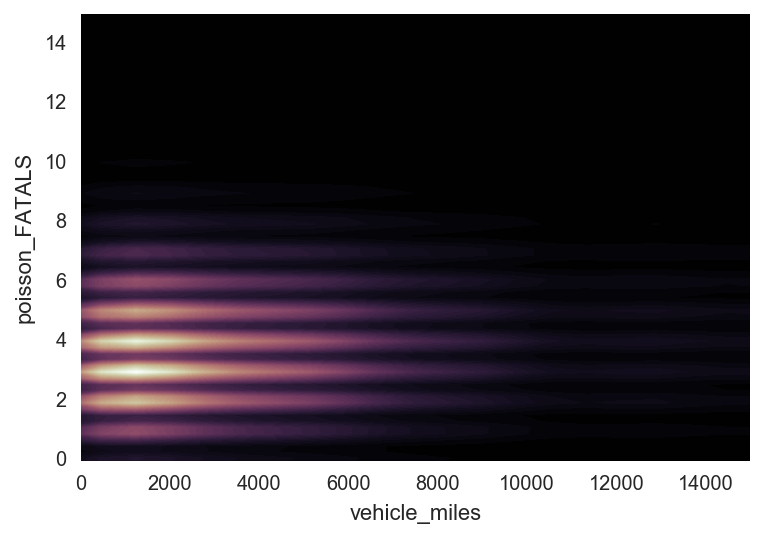

In [92]:
p = sns.kdeplot(models_sim.vehicle_miles,
                models_sim.poisson_FATALS,
                cmap=kde_cmap,
                n_levels=75,
                shade=True)
p.set(xlim=(0,15000), ylim=(0,15))

In [96]:
glm_nbinom = sm.GLM(endog, exog, family=sm.families.NegativeBinomial())
nbinom = glm_nbinom.fit()

In [97]:
print(nbinom.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 FATALS   No. Observations:                 2783
Model:                            GLM   Df Residuals:                     2781
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                    1.0590450906
Method:                          IRLS   Log-Likelihood:                -13444.
Date:                Mon, 15 Aug 2016   Deviance:                       2797.4
Time:                        16:59:15   Pearson chi2:                 2.95e+03
No. Iterations:                    31                                         
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
vehicle_miles     0.0001   2.74e-06     41.451      0.000         0.000     0.000
const             3.2417      0.024    133.

In [98]:
vm_coef = nbinom.params[0]
alpha = nbinom.params[1]
print vm_coef, alpha

0.000113375442865 3.24173799125


## Appendix

### Data views

#### `fars` dictionary

In [69]:
road_function_map

,road_fnc,road_fnc_text,rur_urb,rur_urb_text,func_sys,func_sys_text
road_fnc,,,,,,
1,1,Rural-Principal Arterial-Interstate,1,rural,1,interstate
2,2,Rural-Principal Arterial-Other,1,rural,3,principal arterial
3,3,Rural-Minor Arterial,1,rural,4,minor arterial
4,4,Rural-Major Collector,1,rural,5,major collector
5,5,Rural-Minor Collector,1,rural,6,minor collector
6,6,Rural-Local Road or Street,1,rural,7,local
9,9,Rural-Unknown Rural,1,rural,99,unknown
11,11,Urban-Principal Arterial-Interstate,2,urban,1,interstate
12,12,Urban-Principal Arterial-Other (Freeways or Ex...,2,urban,2,freeway


In [1388]:
set(accidents_vm2['state'])

{nan,
 'Alabama',
 'Alaska',
 'Arizona',
 'Arkansas',
 'California',
 'Colorado',
 'Connecticut',
 'Delaware',
 'Florida',
 'Georgia',
 'Hawaii',
 'Idaho',
 'Illinois',
 'Indiana',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Maine',
 'Maryland',
 'Massachusetts',
 'Michigan',
 'Minnesota',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'Nevada',
 'New Hampshire',
 'New Jersey',
 'New Mexico',
 'New York',
 'North Carolina',
 'North Dakota',
 'Ohio',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'Rhode Island',
 'South Carolina',
 'South Dakota',
 'Tennessee',
 'Texas',
 'Utah',
 'Vermont',
 'Virginia',
 'Washington',
 'West Virginia',
 'Wisconsin',
 'Wyoming'}

In [1375]:
vm2.iloc[2:3,0].index

MultiIndex(levels=[[u'Alabama', u'Alaska', u'Arizona', u'Arkansas', u'California', u'Colorado', u'Connecticut', u'Delaware', u'Dist. of Columbia', u'Florida', u'Georgia', u'Hawaii', u'Idaho', u'Illinois', u'Indiana', u'Iowa', u'Kansas', u'Kentucky', u'Louisiana', u'Maine', u'Maryland', u'Massachusetts', u'Michigan', u'Minnesota', u'Mississippi', u'Missouri', u'Montana', u'Nebraska', u'Nevada', u'New Hampshire', u'New Jersey', u'New Mexico', u'New York', u'North Carolina', u'North Dakota', u'Ohio', u'Oklahoma', u'Oregon', u'Pennsylvania', u'Puerto Rico', u'Puerto Rico  (2)', u'Puerto Rico  2/', u'Rhode Island', u'South Carolina', u'South Dakota', u'Tennessee', u'Texas', u'Texas (2)', u'Utah', u'Vermont', u'Virginia', u'Washington', u'West Virginia', u'Wisconsin', u'Wyoming'], [2010, 2011, 2012, 2013, 2014], [u'rural', u'urban'], [u'collector', u'freeway_or_expressway', u'interstate', u'local', u'major_collector', u'minor_arterial', u'other_principal_arterial']],
           labels=[[0], 

In [1385]:
vm2

,state,year,road_area,road_function_xref,vehicle_miles
0,Alabama,2010,rural,collector,1685.570000
1,Alabama,2010,rural,freeway_or_expressway,0.000000
2,Alabama,2010,rural,interstate,5744.605837
3,Alabama,2010,rural,local,6851.415000
4,Alabama,2010,rural,major_collector,4983.954972
5,Alabama,2010,rural,minor_arterial,4800.226643
6,Alabama,2010,rural,other_principal_arterial,6503.179197
7,Alabama,2010,urban,collector,3273.775149
8,Alabama,2010,urban,freeway_or_expressway,591.210765
9,Alabama,2010,urban,interstate,7552.172521


In [1247]:
roads

,road_fnc,road_function_full,road_area,road_function_only
0,1,Rural-Principal Arterial-Interstate,rural,interstate
1,2,Rural-Principal Arterial-Other,rural,other_principal_arterial
2,3,Rural-Minor Arterial,rural,minor_arterial
3,4,Rural-Major Collector,rural,major_collector
4,5,Rural-Minor Collector,rural,minor_collector
5,6,Rural-Local Road or Street,rural,local
6,9,Rural-Unknown Rural,rural,unknown
7,11,Urban-Principal Arterial-Interstate,urban,interstate
8,12,Urban-Principal Arterial-Other Freeways or Exp...,urban,freeway_or_expressway
9,13,Urban-Other Principal Arterial,urban,other_principal_arterial


In [42]:
accidents_by_vm.head()

,YEAR,state,road_area,road_function_xref,vehicle_miles,FATALS,rate,road_function,log_vehicle_miles,log_fatalities
0,2010,Alabama,rural,interstate,5744.605837,50.0,0.008704,arterial,8.656017,3.912023
1,2010,Alabama,urban,interstate,7552.172521,41.0,0.005429,arterial,8.929591,3.713572
2,2010,Alaska,rural,interstate,858.995539,18.0,0.020955,arterial,6.755764,2.890372
3,2010,Alaska,urban,interstate,663.146376,9.0,0.013572,arterial,6.496996,2.197225
4,2010,Arizona,rural,interstate,7132.905012,103.0,0.014440,arterial,8.872474,4.634729


In [90]:
road_function_groups

,road_function,road_function_xref
0,collector,major_collector
1,arterial,freeway_or_expressway
2,arterial,other_principal_arterial
3,collector,collector
4,collector,minor_collector
5,arterial,minor_arterial
6,local,local
7,arterial,interstate


In [269]:
accidents_by_vm

,YEAR,state,road_area,road_function_xref,vehicle_miles,FATALS,rate,road_function,log_vehicle_miles,log_fatalities
0,2010,Alabama,rural,interstate,5744.605837,50.0,0.008704,arterial,8.656017,3.912023
1,2010,Alabama,urban,interstate,7552.172521,41.0,0.005429,arterial,8.929591,3.713572
2,2010,Alaska,rural,interstate,858.995539,18.0,0.020955,arterial,6.755764,2.890372
3,2010,Alaska,urban,interstate,663.146376,9.0,0.013572,arterial,6.496996,2.197225
4,2010,Arizona,rural,interstate,7132.905012,103.0,0.014440,arterial,8.872474,4.634729
5,2010,Arizona,urban,interstate,6064.827159,45.0,0.007420,arterial,8.710261,3.806662
6,2010,Arkansas,rural,interstate,4328.487400,52.0,0.012013,arterial,8.372973,3.951244
7,2010,Arkansas,urban,interstate,4092.658531,20.0,0.004887,arterial,8.316950,2.995732
8,2010,California,rural,interstate,17565.014236,158.0,0.008995,arterial,9.773664,5.062595
9,2010,California,urban,interstate,68206.775561,235.0,0.003445,arterial,11.130299,5.459586


In [64]:
poisson_sim.head()

,YEAR,state,road_area,road_function_xref,vehicle_miles,FATALS,road_function
0,2010,Alabama,rural,interstate,5744.605837,50.0,arterial
1,2010,Alabama,urban,interstate,7552.172521,41.0,arterial
2,2010,Alaska,rural,interstate,858.995539,18.0,arterial
3,2010,Alaska,urban,interstate,663.146376,9.0,arterial
4,2010,Arizona,rural,interstate,7132.905012,103.0,arterial


### Save data

In [59]:
with open('data/lat_long.csv', 'w') as ll:
    accidents.to_csv(ll, columns=('LATITUDE', 'LONGITUD'))

## Deprecated Code

In [ ]:
"""     
        Older, unused function.
        Intended for parsing Excel .XLS and .XLSX files to find sensible column names
        for dataframes, especially for traffic data from FHWA website.
        No longer needed because column names are now generated from reusable road_type 
        and vehicle_type lists then specified in traffic_table_format dictionary.
"""

"""
def get_column_names(excel_file, first_value):
    with pd.ExcelFile(excel_file) as excel:
        try:
            df = excel.parse(str(excel.sheet_names[0]))
            print 'Trying {sn}'.format(sn=str(excel.sheet_names[0])) 
            first_row = df.index[df.iloc[:,0].str.contains(first_value)==True][0]
        except:
            df = excel.parse(str(excel.sheet_names[1]))
            first_row = df.index[df.iloc[:,0].str.contains(first_value)==True][0]
            print 'Switched to {sn}'.format(sn=str(excel.sheet_names[1]))
    names = df.iloc[:first_row].apply(lambda x: ''.join(str(x).strip()))
    print names
    new_names = []
    for name in names:
        new_name = re.sub('NaN\s*','', name)
        new_name = re.sub('Name: (Unnamed:)? (\d+)?, dtype: object','', new_name)
        new_name = re.sub('\d+\s{4}\s*','', new_name)
        new_name = re.sub('\\n', ' ', new_name)
        new_name = re.sub(' \d?\/ ?', '', new_name)
        new_name = re.sub(' $', '', new_name)
        new_names.append(new_name)
        new_names[0] = re.findall('\w+$', new_names[0])[0]
        new_names[len(new_names)-1] = re.sub('^TABLE [^ ]* ', '', 
                                            new_names[len(new_names)-1])
    print new_names
    return new_names
"""

In [16]:
""" 
        Older, unused code.
        Intended for finding Excel .XLS and .XLSX files downloaded from FHWA website.
        No longer needed because
            1.  FHWA data files now selected for download using traffic_tables list
            2.  Local file structure reorganized
"""

"""        
excel_path = 'data/xlsx'
excel_files = os.listdir(excel_path)
excels = pd.DataFrame(data=excel_files, columns=['filename'])
file_year = []
source_table = []
description = []
full_path = []
for e in excels.filename:
    file_year.append(re.findall('(\d{4}).xlsx?$', e)[0])
    source_table.append(re.findall('_([^_]*)_\d{4}.xlsx?$', e)[0])
    description.append(re.findall('^(\w+)_[^_]*_\d{4}.xlsx?$', e)[0])
    full_path.append('{ep}/{fn}'.format(ep=excel_path, fn=e))
excels['year'] = file_year
excels['source_table'] = source_table
excels['description'] = description
excels['full_path'] = full_path
"""

In [18]:
""" 
        Older, unused code.
        Intended for tabulating details of Excel .XLS and .XLSX files downloaded from FHWA website.
        No longer needed because
            1.  FHWA data files now selected for download using traffic_tables list
            2.  Local file structure reorganized
"""

"""
excel_dict = {}
for i in range(excels.shape[0]):
    i_df = clean_excel(excels.full_path[i], 'Alabama', 'Wyoming')
    i_df['FILE_YEAR'] = excels.year[i]
    df_name =  excels.source_table[i]
    if excel_dict.has_key(df_name):
        frames = [i_df, excel_dict[df_name]]
        excel_dict[df_name] = pd.concat(frames) 
    else:
        excel_dict[df_name] = i_df
"""